# HW3. Part 4. CNN Autoencoder 

In [1]:
# importing modules
from utils import load_data
from models import AutoEncoder
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# The following two lines let us reload external modules in the notebook
%load_ext autoreload
%autoreload 2

# Data Description

On this notebook, we are going to work on farsi OCR dataset. As its name implies, it is like famous **MNIST** dataset but it consists of images of handwritten digits in farsi. Each instance of this dataset is 32 * 32 gray-scale image. It is totally composed of 80000 instances.
Train, test sets are loaded using a method in `utils.py`. Training set includes 0.8 of the whole dataset and the rest is the test set.

# Problem Definition
The problem we define for this dataset is to reconstruct original image after making some random rotations. We want to develop a model which recieves as input a rotated image and outputs its original without rotation. Meanwhile, a latent embedding is learned in the training process which its quality will be investigated later.

First, data loader is called which returns original, rotated and labels for both training and test set. After that from each class on instance is plotted with its rotated counterpart.

In [2]:
X_train, X_train_rotated, Y_train, X_test, X_test_rotated, Y_test = load_data()

Loading the whole dataset...


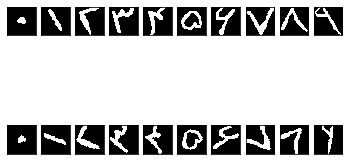

In [3]:
# define a subplot of size 2 * number of classes
num_class = 10
fig, ax = plt.subplots(nrows=2, ncols=num_class)

for i in range(num_class):
    # gather original images of class i
    class_i_images = X_train[Y_train == i]
    
    # gather rotated images of class i
    class_i_rotated = X_train_rotated[Y_train == i]
    
    # make x and y axis invisible to have a better visualization
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    
    # plotting original image of class i
    ax[0, i].imshow(np.squeeze(class_i_images[0]))
    
    # plotting rotated image of class i
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)
    ax[1, i].imshow(np.squeeze(class_i_rotated[0]))

# Setting of Flags

A detailed description about using flags is presented in MLP notebook. So we skip any further explanation here.

In [4]:
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('f', '', 'kernel')
flags.DEFINE_float('learning_rate', 0.0005, 'Initial learning rate')
flags.DEFINE_integer('width', 32, 'Width of images')
flags.DEFINE_integer('height', 32, 'Height of images')
flags.DEFINE_integer('num_channel', 1, 'Number of channels of images')
flags.DEFINE_integer('batch_size', 10, 'Width of images')
flags.DEFINE_integer('num_epochs', 5, 'Number of epochs of training')
flags.DEFINE_integer('code_size', 256, 'Size of intermediate embedding')

# Defining Initializers

Zero and Noraml intializers are defined in `utils.py`.

# Defining Model

There is a partly coded class called `AutoEncoder` in `models.py` which has 5 methods for you to complete. In order to develop you model you have to some layers defined in `layers.py` which also require to get completed. 

Please fill them based on their explanation and then run following cell which defines an AutoEncoder model with **ReLU** as activation function.

In [5]:
model = AutoEncoder()

(?, 32, 32, 8)
(?, 16, 16, 8)
(?, 16, 16, 16)
(?, 8, 8, 16)
(?, 8, 8, 32)
(?, 4, 4, 32)
(?, 512)
(?, 256)
(?, 512)
(?, 4, 4, 32)
(?, 8, 8, 16)
(?, 16, 16, 8)
(?, 32, 32, 1)


After building the computation graph of the model, training process should be started by running a session. The following cell runs a session and computes the total loss on each epoch as well.



In [6]:
# session
sess = tf.Session()

# initialize the graph
sess.run(tf.global_variables_initializer())

# running epochs
for epoch in range(FLAGS.num_epochs):
    total_loss = 0.0
    for batch in range(0, X_train.shape[0], FLAGS.batch_size):
        # creating batches
        feed_dict = {
            model.input_original_images: X_train[batch: batch + FLAGS.batch_size],
            model.input_rotated_images: X_train_rotated[batch: batch + FLAGS.batch_size]
        }
        # feeding batches
        _, v_loss = sess.run([model.opt, model.loss], feed_dict=feed_dict)
        total_loss += v_loss
    print('Epoch {} - Total loss: {}'.format(epoch + 1, total_loss))

Epoch 1 - Total loss: 2061.044390693307
Epoch 2 - Total loss: 1378.0447331294417
Epoch 3 - Total loss: 1179.0238782316446
Epoch 4 - Total loss: 1054.182455651462
Epoch 5 - Total loss: 979.9948934316635


Let's plot the reconstruction result for first batch of test set and compare them with their originals ones as well as their rotated version.

In the plot below, rows from 1 to 3 are depicting original, rotated and reconstructed images, respectively.

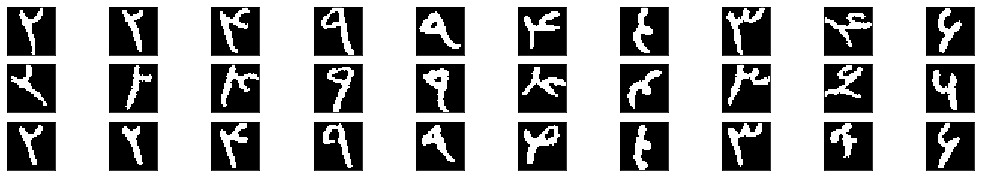

In [7]:
# take a batch from test set
feed_dict = {
    model.input_original_images: X_test[:FLAGS.batch_size],
    model.input_rotated_images: X_test_rotated[:FLAGS.batch_size]
}

# output reconstructed sample
sample_images = sess.run(model.output_images, feed_dict=feed_dict)

# rounding pixels of images
sample_images[sample_images >= 0.5] = 1
sample_images[sample_images < 0.5] = 0

# define a subplot of size 3 * batch size
fig, ax = plt.subplots(nrows=3, ncols=FLAGS.batch_size, figsize=(18, 3))
for i in range(FLAGS.batch_size):
    # plot original test image
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    ax[0, i].imshow(np.squeeze(X_test[i]))
    
    # plot rotated test image
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)
    ax[1, i].imshow(np.squeeze(X_test_rotated[i]))
    
    # plot reconstructed image
    ax[2, i].get_xaxis().set_visible(False)
    ax[2, i].get_yaxis().set_visible(False)
    ax[2, i].imshow(np.squeeze(sample_images[i]))

As mentioned earlier, let's visualize the embedding produced in the middle of network. By doing so, we can discover how high is the quality of embedding encoded for images.

One way to visualize is to use a technique called t-SNE which is basically a dimensionality reduction algorithm. Since the dimension of the latent code is high, it is necessary to use a dimensionality reduction algorithm like t-SNE.

There are two options available here to plot t-SNE diagram:
1. Using class of `TSNE` defined in scikit-learn libray.
2. Tensorboard provides a utility by which embeddings can be visualized.

# t-SNE with scikit-learn

First, codes generated by the network for some training samples are evaluated.

In [8]:
# setting number of samples
num_sample = 1000

# prepare test data samples
feed_dict = {
    model.input_original_images: X_train[:num_sample],
    model.input_rotated_images: X_train[:num_sample]
}
labels = Y_train[:num_sample].astype(int)

# evaluate embedding on samples
embeddings = sess.run(model.code_layer, feed_dict=feed_dict)

A t-SNE class is imported and an object of it constructed. Number of dimensions of new space after reduction is given to constructor. This object has a `fit_transform` method which applies dimension reduction over the input data.

In order to have distinguishable points, we set specific color for each 10 classes of digits as below.

In [9]:
from sklearn.manifold import TSNE

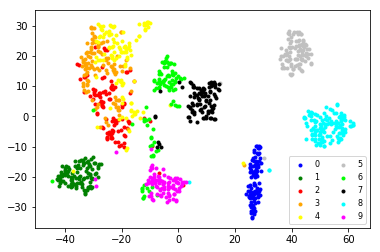

In [10]:
# define TSNE and apply it to the input embedding
tsne = TSNE(n_components=2)
reduced_embeddings = tsne.fit_transform(embeddings)

# set colors and labels
color_names = ['blue', 'green', 'red', 'orange', 'yellow', 'silver', 'lime', 'black', 'cyan', 'magenta']
str_labels = [str(i) for i in range(10)]

# list of scatter plot of embedding for each class
num_class = 10
plts = []
for i in range(num_class):
    plts.append(plt.scatter(reduced_embeddings[labels == i, 0],
                            reduced_embeddings[labels == i, 1]
                            , marker='.', c=color_names[i]))

# set legend
plt.legend(plts, str_labels, 
           scatterpoints=1, loc='best', 
           ncol=2, fontsize=8)

If you have done everything right, then you have to observe how clusters of different classes are well-separated.

# t-SNE with Tensorboard

Here, we use tensorboard to visualize latent codes.

Generally, we define a `tf.Variable` and assign its value to `code_layer` of our model. Then an object of `ProjectorConfig` is constructed to which a new embedding will be added. This is done by setting the tensor name and the path from which metadata should be taken from. Here metadata corresponds to class labels. Metadata `.csv` file is also creted by `write_metadata` function defined below.

Finally a writer is used for saving the embedding and the model is saved by `tf.train.Saver()` to have proper functioning.

In [11]:
from tensorflow.contrib.tensorboard.plugins import projector

In [12]:
import os

# metadata writer
def write_metadata(labels, path):
    with open(os.path.join(path, 'meta_data_labels.csv'), 'w') as csv_file:
        for label in labels:
            csv_file.write(str(label))
            csv_file.write('\n')

In [13]:
import datetime

# set path based on time in logs folder
now = datetime.datetime.now()
path = './logs/' + str(now.hour) + "_" + str(now.minute) + "_" + str(now.second) + "/"
writer = tf.summary.FileWriter(logdir=path, graph=sess.graph)

In [15]:
# shape of sample tensors
tensor_shape = (num_sample, model.code_layer.get_shape()[1].value)
embedding_var = tf.Variable(tf.zeros(shape=tensor_shape), name='embedding')

# assiging available code_layer in graph to new variable
embedding_assign = embedding_var.assign(model.code_layer)

# define config
config = projector.ProjectorConfig()
embedding = config.embeddings.add()  
embedding.tensor_name = embedding_var.name  # set tensor name
embedding.metadata_path = 'meta_data_labels.csv'  # set metadata path
write_metadata(labels, path)  # fill file of metadata
projector.visualize_embeddings(writer, config)

# save embeddings
sess.run(embedding_assign, feed_dict)
saver = tf.train.Saver([embedding_var])
saver.save(sess, os.path.join(path, 'embedding_layer.ckpt'), 1)

'./logs/11_8_24/embedding_layer.ckpt-1'

After running the above code you have to run tensorboard on the path specified in the code.



In [16]:
sess.close()

### **Note**: 

For this notebook please just include the tensorboard t-SNE visualization of encoded images beside your uploaded files.
To do so, you can take screenshot and save it as an image with name `tsne_visual`.